#### Selección del modelo:


Para hacer un mapeo rápido de posibilidades usaremos Pycaret. Pycaret nos permite testear de manera rápida los modelos y poder tener una idea general de qué está funcionando para nuestros datos. En este caso usaremos 90% 10% para train y test. Más allá del Cross Validation que Pycaret ya hace por dentro de por sí. 


In [1]:
#Probando mlflow
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    metrics_dict = {'RMSE':rmse, 'MAE': mae, 'R2':r2}
    return metrics_dict

In [2]:
#Load data and set seed
seed = 40

warnings.filterwarnings("ignore")
np.random.seed(seed)
# Read the csv file from the path
csv_path = (
    "../data/2020_Notebook03_train_output.csv",
    "../data/2020_Notebook03_test_output.csv"
)

try:
    train = pd.read_csv(csv_path[0]).drop(["latitud","longitud"], axis=1)
    test = pd.read_csv(csv_path[1]).drop(["latitud","longitud"], axis=1)
    
except Exception as e:
    logger.exception(
        "Unable to load training & test CSV. Error: %s", e
    )

In [3]:
#train_x = train.select_dtypes(exclude='object').drop(["Precio_m2_total"], axis=1)
#test_x = test.select_dtypes(exclude='object').drop(["Precio_m2_total"], axis=1)
#train_y = train[["Precio_m2_total"]]
#test_y = test[["Precio_m2_total"]]

data = pd.concat([train,test]).reset_index(drop=True)
data_train = data.sample(frac=0.9, random_state=123)
data_test = data.loc[data.index.difference(data_train.index),:]

In [4]:
data_train.describe()

,Ciudad,Area_total,Area_constr,Area_constr_cat,NroBanios,Dormitorios,Antiguedad,Cocheras,areas_diff,areas_proporcion,...,restaurant_poi_count,school_poi_count,bus_station_poi_count,college_poi_count,university_poi_count,marketplace_poi_count,police_poi_count,local_average_bedrooms,local_average_total_area,Precio_m2_total
count,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,...,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000,3646.000000
mean,1.950631,447.385080,330.976961,9.286890,3.665112,4.436643,23.146736,2.606418,116.408118,1.324070,...,7.241909,5.314591,0.196380,0.329402,0.267965,0.496434,0.371640,4.430406,450.367387,5077.253152
std,0.222909,332.984429,160.826352,5.644715,0.983276,1.187367,9.789198,1.067054,241.451270,0.591213,...,10.356401,5.606340,0.820083,0.947654,1.242723,1.028730,0.713081,0.000998,0.571400,1908.360711
min,0.000000,40.000000,31.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-400.000000,0.279487,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.426314,446.703862,21.200000
25%,2.000000,240.000000,220.000000,5.000000,3.000000,4.000000,17.000000,2.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.430017,450.437037,3580.000000
50%,2.000000,330.000000,302.000000,9.000000,4.000000,4.000000,21.000000,2.000000,5.500000,1.017351,...,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.430264,450.517650,5132.495054
75%,2.000000,530.000000,400.750000,14.000000,4.000000,5.000000,30.000000,3.000000,144.750000,1.503358,...,11.000000,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.430370,450.548013,6516.740379
max,2.000000,2580.000000,1010.000000,19.000000,20.000000,20.000000,65.000000,6.000000,1878.000000,3.975000,...,121.000000,45.000000,23.000000,15.000000,46.000000,11.000000,4.000000,4.435807,451.294627,8997.641509


In [5]:
from pycaret.regression import *

exp_101 = setup(data = data_train.select_dtypes(exclude='object'),
               target = "Precio_m2_total", session_id = 104,
               normalize = True, remove_multicollinearity = True, log_experiment = True,
               experiment_name = 'experiment_201(spatial_features)')

,Description,Value
0,session_id,104
1,Target,Precio_m2_total
2,Original Data,"(3646, 24)"
3,Missing Values,False
4,Numeric Features,22
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2552, 23)"


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='Precio_m2_total',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_...
                ('dummy', Dummify(target='Precio_m2_total')),
                ('fix_perfect', Remove_100(targ

In [6]:
top_3_models = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,928.8200,1579434.5814,1254.0248,0.5739,0.3215,0.3711,0.7490
rf,Random Forest Regressor,952.6022,1609660.3797,1266.0610,0.5661,0.3236,0.3728,0.9990
lightgbm,Light Gradient Boosting Machine,961.3139,1608709.1706,1266.2415,0.5651,0.3215,0.3796,0.7510
gbr,Gradient Boosting Regressor,985.0993,1638780.2638,1278.1933,0.5572,0.3295,0.3982,0.2840
xgboost,Extreme Gradient Boosting,983.8971,1724454.6250,1311.3281,0.5341,0.3433,0.3718,1.2520
ada,AdaBoost Regressor,1147.5644,2060613.6767,1434.1645,0.4425,0.3701,0.4346,0.1070
lr,Linear Regression,1159.7486,2109472.0250,1451.4590,0.4292,0.3865,0.4410,1.0080
ridge,Ridge Regression,1159.7897,2109680.8000,1451.5421,0.4291,0.3864,0.4410,0.0160
lasso,Lasso Regression,1160.2093,2110179.4875,1451.7169,0.4289,0.3860,0.4412,0.0180
br,Bayesian Ridge,1161.4849,2110583.6642,1451.8703,0.4288,0.3860,0.4418,0.0170


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=104, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_job

In [7]:
lgbm = create_model('lightgbm', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,980.2387,1624101.9177,1274.4026,0.5751,0.3004,0.2467
1,980.2517,1592681.6126,1262.0149,0.5868,0.3484,0.3121
2,948.7957,1600595.1189,1265.1463,0.5751,0.3873,0.8676
3,955.6114,1670942.9034,1292.6496,0.5182,0.2894,0.2242
4,942.4406,1482623.8678,1217.6304,0.5916,0.2912,0.2402
Mean,961.4676,1594189.0841,1262.3688,0.5693,0.3234,0.3782
SD,15.8877,62090.3111,24.7835,0.0264,0.0385,0.2465


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 3
INFO:logs:LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=104, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


In [8]:
tuned_lgbm = tune_model(lgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1105.1834,2013037.8072,1418.8156,0.4878,0.3356,0.2817
1,963.5125,1583072.5506,1258.2021,0.5713,0.3330,0.2625
2,940.7649,1488838.7685,1220.1798,0.5681,0.3240,0.2576
3,1138.1636,2044664.2664,1429.9176,0.5210,0.4232,0.4473
4,1042.2546,1857897.4391,1363.0471,0.5063,0.4866,1.5305
5,1034.2221,1764019.1371,1328.1638,0.5306,0.3049,0.2538
6,981.3390,1611753.9340,1269.5487,0.5192,0.2882,0.2267
7,1057.4043,1833120.4878,1353.9278,0.4861,0.3299,0.2733
8,1030.9586,1767523.2240,1329.4823,0.5412,0.3301,0.2849
9,975.8925,1565785.5684,1251.3135,0.5341,0.2986,0.2446


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 4
INFO:logs:LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


## Interpretación del modelo.

Un proyecto de análisis y modelado de datos es iterativo, es decir, vamos a tener que probar diferentes métodos y evaluar sus respectivos resultados. Si bien podemos hacer un seguimiento de esto con herramientas como mlflow, la principal limitante es solo mantener un registro de las métricas que se generen mas no del proceso analítico. Por eso, en este sección pondremos los primeros modelos con sus respectivas interpretaciones y cambios según un índice alfabético.

**Qué metricas seguiremos y por qué?**

1.- MAPE. Mean Absolute Percentage Error: Nos dice qué porcentaje de los valores estimados provienen directamente del error. 

2.- RMSE. Root Mean Squared Error: Es la métrica más sensible a outliers que tenemos. Nuestros datos tienen outliers, asi que es importante poder tratarlos adecuadamente. Se busca una caída en esta métrica.



**(a) Modelo Base** 
    
    Features: Barrio, Ciudad, Area_total, Area_constr, Area_constr_cat, NroBanios, Dormitorios, Antiguedad, Cocheras, MONEDA.
    nro_features: 10
    train_size = 4980
    test_size = 554
    best_fit = LGBM
    Métricas en train: (MAE,1730) (RMSE, 2730.67) (R2, 0.42) (RMSLE, 0.55) (MAPE, 1.481)
    Conclusión: El modelo subestima el precio de metros cuadrados y la relación con el Area_total es opuesta a la esperada.
    
**(b) Segunda iteración**

    Features: Modelo Base + Diferencias area total - area constr.
    Cambios: Más tratamiendo de outliers
    nro_features: 11
    train_size = 4973
    test_size = 553
    best_fit = LGBM
    Métricas en train: (MAE,1687) (RMSE, 2644.553) (R2, 0.45) (RMSLE, 0.46) (MAPE, 0.5567)
    Conclusión: Sigue habiendo outliers pero estos afectan algo menos a la inferencia. Mejoran las métricas.
    
**(c) Tercera iteración**

    Features: Segunda Iteracion - MONEDA + features de area c/r a la media del distrito
    Cambios: Más tratamientos de outliers
    nro_features: 12
    train_size = MAE: 1687.2510	RMSE: 7321601.9211	R2:0.4459	RMSLE: 0.4614	MAPE: 0.5567
    
**(d) Cuarta iteración Primer modelo Espacial**

    Feautures: Tercera iteración + features espaciales.
    Cambios: Se agregan columnas de datos espaciales
    nro_features: 30
    train_size = 
    test_size =
    best_fit = ET
    Métricas en train: MAE: 1026.9695	RMSE: 1752971.3183	R2:0.5266	RMSLE: 0.3454	MAPE: 0.4063

In [10]:
len(test.columns)

30

##### Gráfico de residuales:

Los residuales son la diferencia entre la muestra observada y predicha. (Y - Ý). En este gráfico podemos ver si el modelo presenta heteroscedasticidad, además de observar qué tanto está subestimando o sobrestimando la variable objetivo.

**(a)** Sí presenta heteroscedasticadad. Un modelo no-lineal es adecuado. El modelo sobrestima los precios de una manera más pronunciada dada una mayor cola en los residuales negativos donde el precio predicho es mayor que el objetivo. Esto no quiere decir que haya más proporción de sobrestimación, sino que las sobrestimaciones son más dispersas. A partir de 8000 soles por m2 (predicho) los errores se vuelven más pronunciados.

**(b)** Se sigue teniendo la presencia de outliers pero estos parecen ser menos a excepción dos.

**(c)** 

**(d)** Los residuales se ajustan a una distribución normal, 

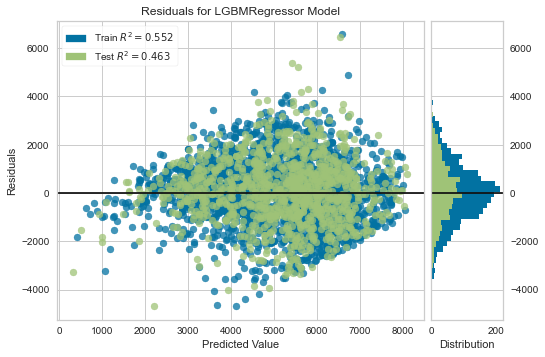

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [11]:
plot_model(tuned_lgbm)

##### Gráfico de tendencia del error. 

Este gráfico muestra la correlación entre los valores predichos y valores reales. Nos va a permitir ver también qué tanta varianza tienen nuestras predicciones, además de ayudarnos a comprar con un fit 'ideal' representado por una línea de 45 grados.

**(a)** Al parecer la varianza es poca y se incrementa cuando el modelo subestima los precios. Dado que la recta está por debajo de los 45 grados, se puede decir que en su mayoría el modelo subestima los precios pero en menor cantidad.

**(b)** El modelo parece haber aumentado su varianza y tiende más a subestimar los precios totales de las casas.

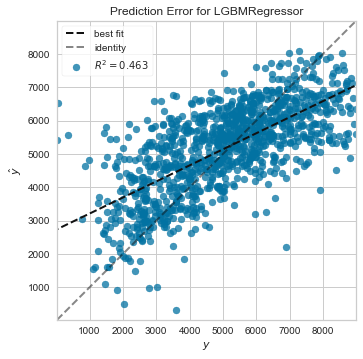

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [12]:
plot_model(tuned_lgbm, plot='error')

##### Distancia de Cooks.

Este gráfico responde a qué tanta influencia tienen los datos cuando se usa una regresión lineal por MCO. Nos sirve para detectar puntos de datos que son altamente influentes en nuestra regresión. 

**(a)** Se confirma que hay outliers que marcan bastante los datos. Cabe resaltar que ya se han removido outliers pero aún queda algunos marcados. El porcentaje de outliers es de 4.10% 

**(b)** El porcentaje de outliers que impactan la tendencia baja a 3.98%. Aún son muy marcados.

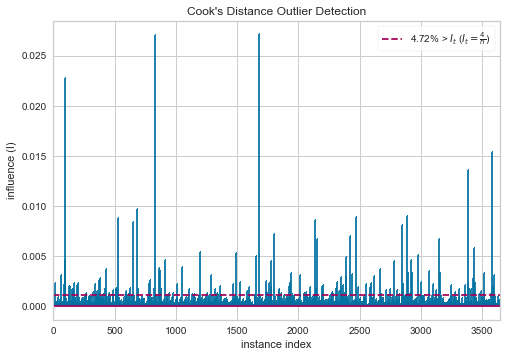

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [13]:
plot_model(tuned_lgbm, plot='cooks')

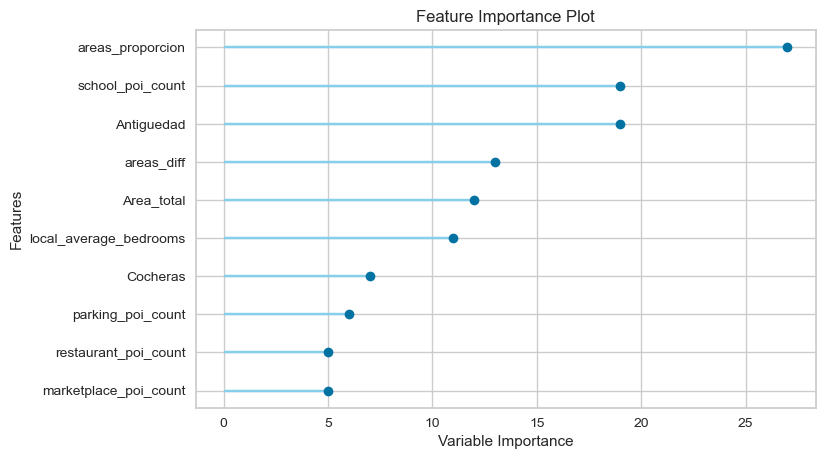

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [14]:
plot_model(tuned_lgbm, plot='feature')

##### SHAP Values. Importancia de variables.

Nos ayuda a explicar de manera agregada modelos complejos. Es importante notar que los valores en la barra (Feature Value) están ordenados por el valor de la variable en sí y las variables en el eje Y aparecen con respecto a qué tanto aportan cambios en esta variable para explicar cambios en el target. 

**(a)** Parece extraño que este gráfico nos dice que mientras que el Area_total sea menor impactara de manera positiva (incrementará) el valor de nuestro target. Al igual que en la antiguedad. Por lo demás genera sentido. Hay que tener también en cuenta que Pycaret genera features por dentro, y que esto puede influir en el modelo.

**(b)** Diferencias negativas en las áreas parecen tener un impacto positivo en el precio. Es decir, mientras el area total sea mucho mayor que el area construida el precio aumenta. También hay que considerar que esto depende del Barrio. Puede ser la presencia de terrenos gigantes en los datos lo que sigue esta tendencia. Además, el valor alto de dormitorios impactando de manera negativa hace algo de ruido.

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), use_train_data=False, X_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


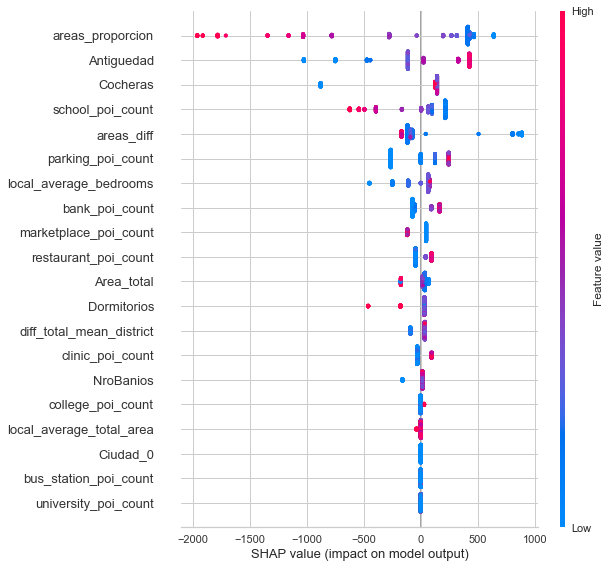

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [15]:
interpret_model(tuned_lgbm)

#### TEST

In [16]:
predictions_df = predict_model(tuned_lgbm, data = data_test.select_dtypes(exclude='object').drop("Precio_m2_total",axis=1))

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


#### Eval_metrics: 

(c) {'RMSE': 2426.879942140638,
 'MAE': 1658.665528733884,
 'R2': 0.45111185284384636}
 
(d) {'RMSE': 1391.2486065477074,
 'MAE': 1066.0242117616615,
 'R2': 0.46109527212512535}

In [17]:
eval_metrics(data_test["Precio_m2_total"], predictions_df['Label'])

{'RMSE': 1391.2486065477074,
 'MAE': 1066.0242117616615,
 'R2': 0.46109527212512535}

In [24]:
tuned_lgbm

LGBMRegressor(bagging_fraction=1.0, bagging_freq=6, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=46, min_child_weight=0.001, min_split_gain=0,
              n_estimators=150, n_jobs=-1, num_leaves=2, objective=None,
              random_state=104, reg_alpha=0.7, reg_lambda=5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=104, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### MLFLow:

In [17]:
def _get_params(estimator):
    """
    Obtendremos los parametros del estimador como forma de diccionario para llamar y loggear.
    """
    all_params = estimator.get_params()

    params_to_log = {k:v for k,v in all_params.items() if k in ['alpha','fit_intercept']} #Esto es lo configurable.
    
    return params_to_log
    
def _get_metrics(y_true, y_pred):
    """
    y_pred: predicciones.
    y_true: valores reales del test.
    
    Retornaremos las métricas del estimador como forma de diccionario para llamar y loggear.
    """
    
    metrics_to_log = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE' : mean_absolute_error(y_true, y_pred),
        'R2' : r2_score(y_true, y_pred),
        'MSE' : mean_squared_error(y_true, y_pred)
    }
    
    return metrics_to_log

def log_metrics_params(metrics_to_log, params_to_log):
    for nombre_metrica, valor_metrica in metrics_to_log.items():
        mlflow.log_metric(nombre_metrica, valor_metrica)
    
    for nombre_param, valor_param in params_to_log.items():
        mlflow.log_param(nombre_param, valor_param)

def _my_scorer(estimator, X_test, y_test):
    """
    Esta función va dentro del Loop del GridSearch. Después del fit y antes de la evaluación.
    
    Acá también llamaremos a MlFlow para tener un tracking de los modelos. Así como loggear el mejor modelo luego.
    Podemos aprovechar para loggear entre los batchs.
    
    """
    n = 0
    with mlflow.start_run():
        n+=1
        
        preds = estimator.predict(X_test)
        metricas = _get_metrics(y_test, preds)
        params = _get_params(estimator)
        log_metrics_params(metricas, params)
        est_name = estimator.__class__.__name__
    
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        if tracking_url_type_store != 'file':
            mlflow.sklearn.log_model(estimator, "{}_{}".format(est_name, str(n)),
                                     registered_model_name = "{}_{}".format(est_name, str(n)))
                                                              
        else:
            mlflow.sklearn.log_model(estimator, "{}_{}".format(est_name, str(n)))
        
    return metricas['MSE']

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lasso = Lasso()

parameters = {
    'alpha' : [0.1, 0.5, 2, 4],
    'fit_intercept':[True, False]
}

grid_pipe = GridSearchCV(lasso, parameters, scoring=_my_scorer,cv = 2)

grid_pipe.fit(train_x, train_y)

grid_pipe.best_params_

NameError: name 'train_x' is not defined

In [ ]:
import pycaret

In [ ]:
#Idealmente se crea un sys.argv para poder pasar un argumento desde un .sh 

#alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5        #<----------------------
#l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5     #<----------------------

alpha = 0.5
l1_ratio = 0.5

In [ ]:
#Creamos un experimento de MLFlow
experiment_id = mlflow.create_experiment("Linear Models")
experiment = mlflow.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

In [ ]:
LinearRegression().get_params()

In [ ]:
with mlflow.start_run(): ### Qué hace esto..
    
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state = seed)
    lr.fit(train_x, train_y)
    
    predicciones = lr.predict(test_x)
    
    (rmse, mae, r2) = eval_metrics(test_y, predicciones)
    
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    
    #Ahora haremos el log de los parámetros:
    
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme #<-----------------------------
    
    if tracking_url_type_store != "file":
        
        #Existen varias formas de hacer el registro del modelo.
        
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticNet_1")
        
    else:
        mlflow.sklearn.log_model(lr,"model")

Fuentes:

https://danielhnyk.cz/adding-callback-to-a-sklearn-gridsearch/

https://stackoverflow.com/questions/61783042/is-there-a-standard-way-to-implement-callbacks-with-gridsearchcv

